## **Part III**: Multilingual analysis of COVID-19 misinformation

- *Datasets used:* Multi_lang_COVID_msinforamtion
- *Goal:* Study the relationship between COVID Wikipedia pages for different languages. Since the Wikipedia pages in different languages don't have the same structure (so we cannot compare main headings), we want to analyse the links they refer to. What kind of overlap is there between each languages?



#### Libraries

In [133]:
import pandas as pd
from urllib.parse import unquote
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from itertools import combinations
import holoviews as hv
from holoviews import opts, dim
import matplotlib.pyplot as plt
import math

In [134]:
# Function to extract and clean text from links
def extract_clean_text(links):
    cleaned_links = []
    if links:
        for link in links:
            if isinstance(link, str):
                # Check if the link starts with '/wiki/' and does not start with 'https://'
                if link.startswith("/wiki/") and not link.startswith("https://"):
                    extracted_text = link.split("/wiki/")[1].split("#")[0].replace('_', ' ')
                    
                    # Unquote and split the list
                    extracted_text_parts = unquote(extracted_text).split()
                    
                    # Remove parentheses
                    cleaned_text_parts = [word.replace('(', '').replace(')', '') for word in extracted_text_parts]
                    
                    cleaned_links.extend(cleaned_text_parts)
    
    # Remove specific words
    stop_words = {'and','from', 'of', '&', 'in', 'the','on','for', 'covid','19', 'COVID–19','COVID', 'pandemic', '-', }  
    cleaned_links = [word for word in cleaned_links if word.lower() not in stop_words]
    
    return cleaned_links

In [135]:
def read_csv_convert_list(file_path, columns):
    df = pd.read_csv(file_path)
    for column in columns:
        df[column] = df[column].apply(eval)
    return df

In [136]:
def is_english_wikipedia(link):
    return 'https://en' in link


In [154]:
# Function to generate word cloud object
def generate_word_cloud(cleaned_words_list):
    # Create word frequency dictionary
    word_frequency = {word: cleaned_words_list.count(word) for word in set(cleaned_words_list)}
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)
    
    return wordcloud

def create_word_clouds(languages, words_lists, save_to_file=True):
    rows = math.ceil(len(languages) / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(20, 5 * rows))

    for i, language in enumerate(languages):
        wordcloud = generate_word_cloud(words_lists[language])

        row = i // 2
        col = i % 2
        ax = axs[row, col] if rows > 1 else axs[col]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'{language.capitalize()} Word Cloud')

        # Save each word cloud as a PNG file
        if save_to_file:
            fig_single = plt.figure()
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'{language.capitalize()} Word Cloud')
            plt.savefig(f'wordcloud_{language}.png')
            plt.close(fig_single)

    plt.tight_layout()
    if not save_to_file:
        plt.show()



#### Data importation

In [146]:
fetch_data = False
save_data = False

DATA_PATH = "./Data/dif_lang/"
languages = ['fr', 'es', 'ar', 'zh', 'pt', 'de', 'ru', 'it']
if fetch_data:
    url = "https://en.wikipedia.org/wiki/COVID-19_misinformation" # Reference URL
    # Gets equivalent URL of reference URL in other languages
    # Then parses the relevant wiki pages (Main Heading, Sub Headings, Subsubheadings, Links)
    # Then translation we translate the subparts, and equivalent english links are added to the dataframe
    headings_df = multi_lang_df(url, languages) 

    if save_data:
        for lang in languages:
            headings_df[lang].to_csv(DATA_PATH + lang + ".csv", index=False)
else:
    en_col_links = ["Links", "Full Links"]
    otr_lang_col_links = ["Links", "Full Links", 'English Full Links', 'English Relative Links']
    globals()["en"] = read_csv_convert_list(DATA_PATH + "en.csv", en_col_links)
    en.rename(columns={'Full Links': 'English Full Links'}, inplace=True)
    en.rename(columns={'Links': 'English Relative Links'}, inplace=True)
    
    for lang in languages:
        #Create a dataframe for each of the languages
        globals()[lang] = read_csv_convert_list(DATA_PATH + lang + ".csv", otr_lang_col_links)
    

### *Action 3.1:*
- In this section, we only consider articles which had english equivalents. 
- To see the similarities in Wikipedia articles across different languages, we create a pseudo-bag of words for the titles of the equivalent Wikipedia pages about COVID-19 parsed from the Multi_lang_COVID_misinformation.
- We clean the links, separating the words and removing stopwords and words that are over present, and then we count the number of unique words, along with their number frequency to create word clouds for each language.

#### Code

In [148]:
# List of languages
languages = ['es', 'fr', 'it', 'ar', 'de', 'pt', 'ru', 'zh', 'en']

# Create an empty dictionary to store cleaned_words_list for each language
cleaned_words_lists = {}

for lang in languages:
    
    # Create a new column 'English Relative Links usable' with cleaned links
    globals()[lang]['English Relative Links usable'] = globals()[lang]['English Relative Links'].apply(extract_clean_text)
    
    # Flatten the list of cleaned words for each link in the 'usable' column
    cleaned_words_list = [word for links in globals()[lang]['English Relative Links usable'] if links for word in links]
    
    # Store the cleaned_words_list in the dictionary
    cleaned_words_lists[lang] = cleaned_words_list

    # Display the number of unique words for each language
    print(f"Number of unique words for {lang}: {len(cleaned_words_list)}")
    
    # Create a separate list for each language
    locals()[f'cleaned_words_list_{lang}'] = cleaned_words_list


Number of unique words for es: 376
Number of unique words for fr: 2195
Number of unique words for it: 1717
Number of unique words for ar: 2542
Number of unique words for de: 1319
Number of unique words for pt: 560
Number of unique words for ru: 1053
Number of unique words for zh: 1300
Number of unique words for en: 1337


In [ ]:
create_word_clouds(languages, cleaned_words_lists)

#### Results

<img src="Results/PART 3/wordclouds/all_word_clouds.png" alt="alt text" width="600" height="800"/>


Of course, Covid-19 is the most frequent word, and we can use it as baseline to compare the frequency of the other words. In fact, for certain words all the other words are a lot less frequent and with similar frequence. Interestingly, for Spanish, French, and German the biggest words are 'The Times', 'Le monde', and 'United States' respectively. 'conspiracy' and 'trump' have the second place in frequency. Some words we can see that are always present, like 'China', 'vaccine', 'news', but with variable frequency.
In order to quantify better the relationship between languages, we can construct a chord plot with the thickness of the chords tying two languages that is proportional to the overlap of words between the two languages.

### *Action 3.2:*
- In order to quantify better the relationship between languages, we can construct chord plots with the thickness of the chords tying two languages that is proportional to a given overlap metric. We propose two possibilities to study the overlap between these languages.
    - The first is through the count of shared articles between languages.
    - The second is through an evaluation of the Jaccard similarity of bows built for each language out of the titles of articles which were found to have an english equivalent.
- We also investigate the articles which had no english equivalent by calculating what proportion of articles they represented out of all referenced articles.

#### 3.2.1 - Link overlap

##### Code and discussion

In [172]:
# So first we create a dictionary with the overlap for all languages (we have 36 pairs).
tot_words_eng = len(cleaned_words_list_eng)

words_lists = {
    'en': cleaned_words_list_eng,
    'es': cleaned_words_list_es,
    'fr': cleaned_words_list_fr,
    'it': cleaned_words_list_it,
    'ar': cleaned_words_list_ar,
    'de': cleaned_words_list_de,
    'pt': cleaned_words_list_pt,
    'ru': cleaned_words_list_ru,
    'zh': cleaned_words_list_zh,
}

languages_tot = ['en','es', 'fr', 'it', 'ar', 'de', 'pt', 'ru', 'zh']

# Create a dictionary to store overlap counts between language pairs
overlap_dict = {}

# Calculate pairs of languages
language_pairs = list(combinations(languages_tot, 2))

# Fill the dictionary with language pairs and their corresponding overlap counts
for pair in language_pairs:
    lang1, lang2 = pair
    overlap_count = len(set(words_lists[lang1]) & set(words_lists[lang2]))
    overlap_dict[pair] = overlap_count


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
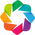

In [173]:
# from chord import Chord

# Extract unique languages
languages = sorted(set(lang for pair in overlap_dict.keys() for lang in pair))

# Create a matrix to represent the overlaps
overlap_matrix = [[overlap_dict.get((lang1, lang2), 0) for lang2 in languages] for lang1 in languages]

hv.extension('bokeh')
hv.output(size=250)


languages = ['English','Spanish', 'French', 'Arab', 'German', 'Portuguese', 'Russian', 'Chinese', 'Italian']

# Create a list of links
links = []
for i in range(len(languages)):
    for j in range(i + 1, len(languages)):
        overlap = overlap_matrix[i][j]
        if overlap > 0:
            links.append({'source': languages[i], 'target': languages[j], 'value': overlap})

# Create a DataFrame for links
links_df = pd.DataFrame(links)


In [205]:
# Create a Chord diagram
chord = hv.Chord(links_df)

# Set visual options using .opts
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color='blue',  # Set the color for edges
               labels='index', node_color='lightblue') 
)

# Display the Chord diagram
chord

:Chord   [source,target]   (value)

In [175]:
# Print the overlap dictionary
print(overlap_dict)
print(max(overlap_dict.values()))
print(min(overlap_dict.values()))

{('en', 'es'): 128, ('en', 'fr'): 257, ('en', 'it'): 213, ('en', 'ar'): 221, ('en', 'de'): 220, ('en', 'pt'): 97, ('en', 'ru'): 179, ('en', 'zh'): 162, ('es', 'fr'): 190, ('es', 'it'): 83, ('es', 'ar'): 106, ('es', 'de'): 110, ('es', 'pt'): 58, ('es', 'ru'): 108, ('es', 'zh'): 67, ('fr', 'it'): 208, ('fr', 'ar'): 231, ('fr', 'de'): 233, ('fr', 'pt'): 96, ('fr', 'ru'): 236, ('fr', 'zh'): 172, ('it', 'ar'): 475, ('it', 'de'): 226, ('it', 'pt'): 172, ('it', 'ru'): 236, ('it', 'zh'): 291, ('ar', 'de'): 241, ('ar', 'pt'): 190, ('ar', 'ru'): 287, ('ar', 'zh'): 405, ('de', 'pt'): 93, ('de', 'ru'): 164, ('de', 'zh'): 161, ('pt', 'ru'): 80, ('pt', 'zh'): 98, ('ru', 'zh'): 215}
475
58


##### Results

<img src="Results\PART 3\local_plots_\article_overlap_chord.png" alt="alt text" width="400" height="400"/>


Interestingly, the maximum overlap is represented by the pair Italian-Arab, and the second one by Chinese-Arab. Even most interesting, the minimum overlap is found for spanish and portuguese. But wait! this is just a size effect, because spanish, portuguese, an english have a lower amount of unique words. Let's normalize the data and see how these ralationship change. This essentially comes down to calculating the Jaccard similarity for the pairs of languages (size of the intersection divided by the number of the union of the two sets).

The percentages correspond to the percentage of articles referenced which do not have an english equivalent.

#### 3.2.2 - Jaccard analysis 

##### Code

In [207]:
# Create a dictionary to store the number of unique words for each language
unique_words_count = {lang: len(set(words_lists[lang])) for lang in languages_tot}

# Fill the dictionary with language pairs and their Jaccard similarity
jaccard_similarity_dict = {}

# Calculate Jaccard similarity and fill the dictionary
for pair in language_pairs:
    lang1, lang2 = pair
    intersection_size = len(set(words_lists[lang1]) & set(words_lists[lang2]))
    
    # Calculate Jaccard similarity using the formula: intersection / union
    union_size = unique_words_count[lang1] + unique_words_count[lang2] - intersection_size
    jaccard_similarity = intersection_size / union_size if union_size != 0 else 0
    
    jaccard_similarity_dict[pair] = round(jaccard_similarity, 2)

# Print the Jaccard similarity dictionary
print(jaccard_similarity_dict)
print(max(jaccard_similarity_dict.values()))
print(min(jaccard_similarity_dict.values()))


{('en', 'es'): 0.13, ('en', 'fr'): 0.17, ('en', 'it'): 0.13, ('en', 'ar'): 0.11, ('en', 'de'): 0.14, ('en', 'pt'): 0.08, ('en', 'ru'): 0.14, ('en', 'zh'): 0.12, ('es', 'fr'): 0.19, ('es', 'it'): 0.07, ('es', 'ar'): 0.07, ('es', 'de'): 0.1, ('es', 'pt'): 0.09, ('es', 'ru'): 0.15, ('es', 'zh'): 0.07, ('fr', 'it'): 0.12, ('fr', 'ar'): 0.11, ('fr', 'de'): 0.14, ('fr', 'pt'): 0.08, ('fr', 'ru'): 0.19, ('fr', 'zh'): 0.12, ('it', 'ar'): 0.25, ('it', 'de'): 0.13, ('it', 'pt'): 0.13, ('it', 'ru'): 0.17, ('it', 'zh'): 0.2, ('ar', 'de'): 0.12, ('ar', 'pt'): 0.12, ('ar', 'ru'): 0.18, ('ar', 'zh'): 0.25, ('de', 'pt'): 0.08, ('de', 'ru'): 0.12, ('de', 'zh'): 0.11, ('pt', 'ru'): 0.09, ('pt', 'zh'): 0.1, ('ru', 'zh'): 0.2}
0.25
0.07


##### Results

<img src="Results\PART 3\local_plots_\Jaccard_table.jpg" alt="alt text" width="600" height="300"/>


Now we see that the higher overlap is for Arab-Chinese with 25% jaccard similarity, while the lowest is for English-Portuguese, Spanish-Italian, Spanish-Arab, Spanish-Chinese (only 7%). Intersection with Portuguese are also quite low (always below 13%). It would seem that Spanish and Portuguese are isolated clusters of news, which are rather local and not so international. In fact, for a complete analysis we would have to study in more detail the link pages for which there was no translation (we imagine this number ti be high for spanish and portuguese).

### 3.3 - Comparative histogram

#### Code

In [209]:
# Define the list of languages
languages = ['en', 'fr', 'es', 'ar', 'zh', 'pt', 'de', 'ru', 'it']

# Initialize an empty list to store data for each language
data = []

# Iterate over each language
for lang in languages:
    # Initialize variables for calculating the average overlap
    lang_sum = 0
    common_lang = 0

    # Iterate over each pair in the overlap dictionary
    for pair in overlap_dict:
        # Check if the current language is part of the pair
        if lang in pair:
            common_lang += 1  # Increment the count of common languages
            # Identify the other language in the pair
            other_lang = pair[0] if pair[1] == lang else pair[1]
            # Add the normalized overlap value to the sum
            lang_sum += overlap_dict[pair] / link_counts_df[link_counts_df['Language'] == other_lang]['Unique English Wikipedia Links'].iloc[0]

    # Calculate the average overlap, multiplied by 100 to get a percentage
    avg_overlap = (lang_sum / common_lang) * 100 if common_lang > 0 else 0

    # Access the DataFrame for the current language from global scope
    misinfo_df = globals()[lang].copy()

    # Initialize sets to store unique links
    unique_en_wiki_links = set()
    unique_non_en_wiki_links = set()

    # Iterate over the list of links in the DataFrame
    for links_list in misinfo_df['English Full Links']:
        for link in links_list:
            # Check if the link is from English Wikipedia and add to the respective set
            if is_english_wikipedia(link):
                unique_en_wiki_links.add(link)
            else:
                unique_non_en_wiki_links.add(link)

    # Count the unique links
    en_wiki_count = len(unique_en_wiki_links)
    non_en_wiki_count = len(unique_non_en_wiki_links)

    # Calculate the percentage of unique links
    total_unique_links = en_wiki_count + non_en_wiki_count
    en_wiki_percentage = (en_wiki_count / total_unique_links) * 100 if total_unique_links > 0 else 0
    non_en_wiki_percentage = (non_en_wiki_count / total_unique_links) * 100 if total_unique_links > 0 else 0

    # Append the calculated data for the current language to the list
    data.append({
        'Language': lang,
        'Unique English Wikipedia Links': en_wiki_count,
        'Unique Non-English Wikipedia Links': non_en_wiki_count,
        'Percentage English Wikipedia Links': en_wiki_percentage,
        'Percentage Non-English Wikipedia Links': non_en_wiki_percentage,
        'Percentage Average Overlap': avg_overlap
    })

# Create a DataFrame from the accumulated data
link_counts_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
link_counts_df.head()


,Language,Unique English Wikipedia Links,Unique Non-English Wikipedia Links,Percentage English Wikipedia Links,Percentage Non-English Wikipedia Links,Percentage Average Overlap
0,en,531,0,100.000000,0.000000,42.680962
1,fr,616,64,90.588235,9.411765,51.024347
2,es,152,25,85.875706,14.124294,20.685846
3,ar,889,15,98.340708,1.659292,62.337738
4,zh,498,111,81.773399,18.226601,39.589795


In [203]:
import plotly.express as px

# Assuming link_counts_df is already defined and contains the necessary data
df_melted = link_counts_df.melt(id_vars=['Language'], value_vars=['Percentage English Wikipedia Links', 'Percentage Non-English Wikipedia Links', 'Percentage Average Overlap'],
                                var_name='Category', value_name='Percentage')

fig = px.bar(df_melted, x='Language', y='Percentage', color='Category', barmode='group')

fig.update_layout(
    title="Referenced articles constitution per language",
    xaxis_title="Language",
    yaxis_title="Percentage",
    legend_title="Category",
    barmode='group'
)

fig.show(renderer='browser')

#### Results

<img src="Results\PART 3\local_plots_\article_bar_chart.png" alt="alt text" width="600" height="300"/>


Interpretation:
- The category "Percentage English Wikipedia Links" corresponds to the number of referenced articles in the original language which also exist in english
- The category "Percentage Non-English Wikipedia Links" corresponds to the number of referenced articles in the original language which only exist in the original language
- The category "Percentage Average Overlap" corresponds to the average percentage of articles which are cited in the original and any target language

Validity:
While this graph doesn't tell us about the extent of the spread of misinformation in the countries which use the language, it certainly tells us about how exhaustive the work of Wikipedia Moderators was while trying to report Covid related fake news. This could be in turn interpreted as the general sense of urgency and consideration of Fake news as a whole from 

Analysis:
We can observe that the most exhaustive COVID-19 misinformation article and which references the widest variety of articles is the arabic language one. It is also the one with the smallest amount of articles existing only in the original language.